Training Model...
Epoch 0, Loss: 491054434269265920.0000
Epoch 50, Loss: 491054434269265920.0000
Epoch 100, Loss: 491054434269265920.0000
Epoch 150, Loss: 491054365549789184.0000
Epoch 200, Loss: 491054296830312448.0000
Epoch 250, Loss: 491054193751097344.0000
Epoch 300, Loss: 491053987592667136.0000
Epoch 350, Loss: 491053678355021824.0000
Epoch 400, Loss: 491053197318684672.0000
Epoch 450, Loss: 491052716282347520.0000

Final Test MSE: 485846666163781632.0000

=== Trend Analysis ===
Average Streams - Explicit Songs: 445349873
Average Streams - Non-Explicit Songs: 448563230

Average Streams by Year:
Release Year
1987    1.879386e+09
1991    2.021910e+09
1994    1.810650e+09
1998    1.783399e+08
1999    1.405354e+09
2000    1.921767e+09
2001    3.991452e+08
2002    1.812768e+09
2003    1.502681e+09
2004    1.232601e+09
2005    1.222379e+09
2006    1.096108e+09
2007    1.043205e+09
2008    1.170105e+09
2009    1.079095e+09
2010    9.675554e+08
2011    1.084821e+09
2012    1.250934e+09
2

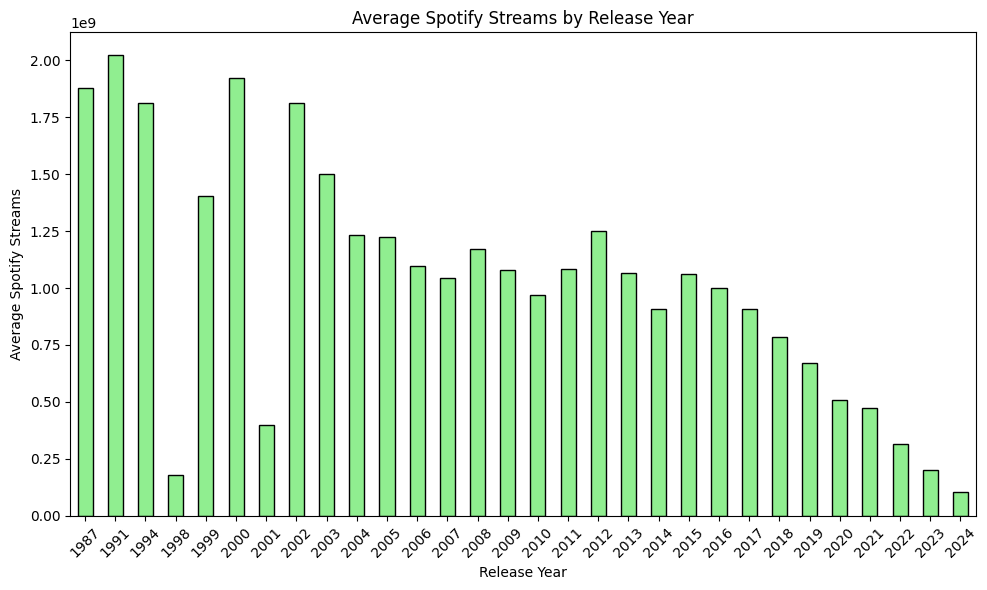


=== Predict Optimal Release Year for New Song ===
Recommended Release Year: 1987


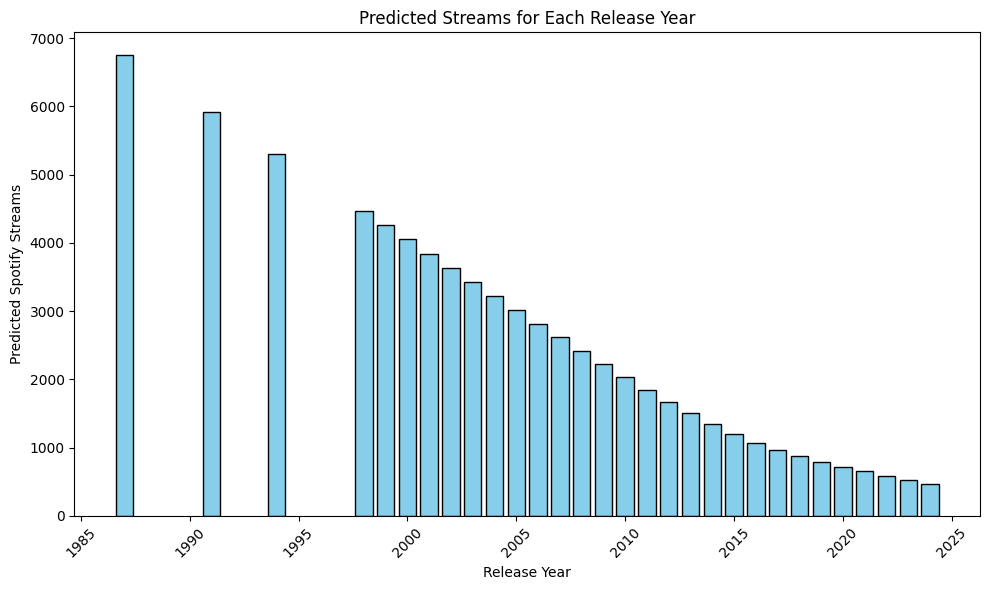

In [4]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load Dataset
csv_path = "Spotify_Data.csv"
df = pd.read_csv(csv_path, encoding='latin1')

# ============================
# Data Cleaning & Processing
# ============================
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Year'] = df['Release Date'].dt.year

# Convert numeric fields
df['Spotify Streams'] = df['Spotify Streams'].str.replace(',', '', regex=False).astype(float)
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].str.replace(',', '', regex=False).astype(float)
df['Spotify Playlist Reach'] = df['Spotify Playlist Reach'].str.replace(',', '', regex=False).astype(float)

# Drop rows missing critical values
df = df.dropna(subset=['Release Year', 'Spotify Streams'])

# ======================
# Features and Target
# ======================
X = df[['Release Year', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Explicit Track']].fillna(0)
y = df['Spotify Streams']

# ===========================
# Scale and Convert to Tensors
# ===========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# =====================
# Define Neural Network
# =====================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ====================
# Training Loop
# ====================
print("Training Model...")
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ====================
# Evaluation
# ====================
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    print(f"\nFinal Test MSE: {mse.item():.4f}")

# ====================
# Trend Analysis
# ====================
print("\n=== Trend Analysis ===")

# Explicit Songs Performance
explicit_avg = df[df['Explicit Track'] == 1]['Spotify Streams'].mean()
non_explicit_avg = df[df['Explicit Track'] == 0]['Spotify Streams'].mean()
print(f"Average Streams - Explicit Songs: {explicit_avg:.0f}")
print(f"Average Streams - Non-Explicit Songs: {non_explicit_avg:.0f}")

# Average Streams by Release Year
year_avg = df.groupby('Release Year')['Spotify Streams'].mean()
print("\nAverage Streams by Year:")
print(year_avg)

# Plot Average Streams by Year
plt.figure(figsize=(10, 6))
year_avg.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average Spotify Streams by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average Spotify Streams')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================
# Predict Optimal Release Year
# ===========================
def predict_streams_for_each_year(base_features, years):
    predicted_streams = []

    for year in years:
        features = base_features.copy()
        features[0] = year  # Set release year
        scaled_features = scaler.transform(pd.DataFrame([features], columns=X.columns))
        tensor_input = torch.tensor(scaled_features, dtype=torch.float32)
        with torch.no_grad():
            pred = model(tensor_input).item()
        predicted_streams.append(pred)

    return years, predicted_streams

# Example Song: [Release Year, Playlist Count, Playlist Reach, Explicit (0 or 1)]
print("\n=== Predict Optimal Release Year for New Song ===")
example_song = [2024, 10000, 5000000, 1]
unique_years = sorted(df['Release Year'].dropna().unique().astype(int))

years, streams_predicted = predict_streams_for_each_year(example_song, unique_years)
best_year = years[streams_predicted.index(max(streams_predicted))]
print(f"Recommended Release Year: {best_year}")

# Plot Predictions by Year
plt.figure(figsize=(10, 6))
plt.bar(years, streams_predicted, color='skyblue', edgecolor='black')
plt.title('Predicted Streams for Each Release Year')
plt.xlabel('Release Year')
plt.ylabel('Predicted Spotify Streams')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
